## CNN model for hard onset detection

In [2]:
# Autoload libraries
%load_ext autoreload
%autoreload 2

# Main libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import madmom
import mir_eval

# Pre- and postprocessing
from modules.analysis_funcs import get_segmented_data, get_test_peaks
# Dataset handler
from datasets import Dataset
# Model
from models import FINAL_MODEL_PATH
# Visualization functions
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer
# Evaluation
from analyze_detection import evaluate


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Insert reference to audio and annotation files
# Audio should be wav
# Annotation file should contain onsets in seconds (one on each line, without headers)
audio_fname = "datasets/slurtest_add/slurtest_add_audio/slurtest05_FK.wav"
label_fname = "datasets/slurtest_add/new_annotations/slurtest05_FK.txt"

audio, sample_rate = madmom.io.audio.load_wave_file(audio_fname)
true_onsets = np.loadtxt(label_fname, usecols=0)


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


<AxesSubplot:>

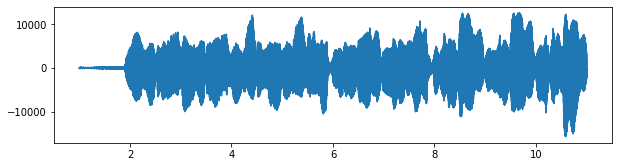

In [18]:

begin = 1 # from seconds
end = 11 # until seconds

# Plot waveform
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

In [20]:
# Load model - detect onsets

framerate = 0.01    # The model outputs activations with this frame rate
model = tf.keras.models.load_model(FINAL_MODEL_PATH)
cnn_input = get_segmented_data(audio)
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, framerate)
print("Number of onsets detected: ", len(cnn_onsets))

Number of onsets detected:  114


<AxesSubplot:>

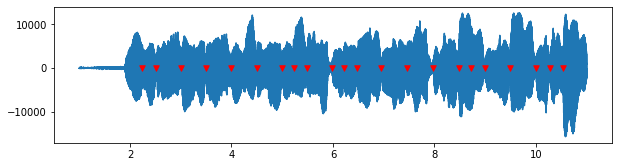

In [21]:
# Plot detections
pred_color = "red"
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ 
            cnn_onsets      # added here
        ],
    [begin,end],
    sr=sample_rate
)[0]
onset_visualizer(passage=passage, ax=ax, onset_styles={"m":["v"], "c":[pred_color]})

In [22]:
# Evaluate the result

TOL = 0.025 # seconds of tolerance window
metrics = mir_eval.onset.evaluate(true_onsets, cnn_onsets, window=TOL)
print("F-measure: ", metrics["F-measure"])
print("Precision: ", metrics["Precision"])
print("Recall: ", metrics["Recall"])

F-measure:  0.8899521531100479
Precision:  0.8157894736842105
Recall:  0.9789473684210527


<AxesSubplot:>

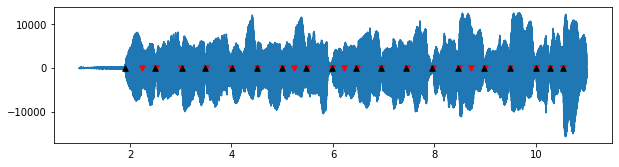

In [23]:
# Plot both detected and true onsets

true_color = "black"
fig,ax = plt.subplots(figsize=(10,2.5))
styles = {"m":["^", "v"], "c":[true_color, pred_color]}
passage = passage_extractor(audio,
        [ 
            true_onsets, 
            cnn_onsets
        ],
    [1,11], # Segment between these seconds to plot
    sr=sample_rate
)[0]
# Function below plots only the content in the passage
onset_visualizer(passage=passage, ax=ax, onset_styles=styles)